### Data Cleaning

In [1]:
import pandas as pd

# Load data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')



**Initial Data Overview**

In [2]:
# Concatenate train and test for unified cleaning
train['is_train'] = True
test['is_train'] = False
combined = pd.concat([train, test], sort=False).reset_index(drop=True)

# Quick structure and missing value overview
print("Shape:", combined.shape)
print("\nMissing Values:")
print(combined.isnull().sum().sort_values(ascending=False))

print("\nColumn Types:")
print(combined.dtypes)


Shape: (12970, 15)

Missing Values:
Transported     4277
CryoSleep        310
ShoppingMall     306
Cabin            299
VIP              296
Name             294
FoodCourt        289
HomePlanet       288
Spa              284
Destination      274
Age              270
VRDeck           268
RoomService      263
PassengerId        0
is_train           0
dtype: int64

Column Types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
is_train           bool
dtype: object


In [3]:
# Add GroupID from PassengerId
combined['GroupID'] = combined['PassengerId'].str.split('_').str[0]

# Subset again now that GroupID exists
missing_hp = combined[combined['HomePlanet'].isna()].copy()

# Try to infer the group's HomePlanet using mode
group_planet = (
    combined.groupby('GroupID')['HomePlanet']
    .agg(lambda x: x.mode().iloc[0] if x.notna().sum() else None)
)

# Map that to missing_hp rows
missing_hp['ImputedGroupPlanet'] = missing_hp['GroupID'].map(group_planet)

# Show a sample
missing_hp[['PassengerId', 'GroupID', 'Cabin', 'HomePlanet', 'ImputedGroupPlanet']].head(10)


,PassengerId,GroupID,Cabin,HomePlanet,ImputedGroupPlanet
59,0064_02,0064,E/3/S,NaN,Mars
113,0119_01,0119,A/0/P,NaN,Europa
186,0210_01,0210,D/6/P,NaN,None
225,0242_01,0242,F/46/S,NaN,None
234,0251_01,0251,C/11/S,NaN,None
274,0303_01,0303,G/41/S,NaN,None
286,0315_01,0315,G/42/S,NaN,None
291,0321_01,0321,F/61/S,NaN,None
347,0382_01,0382,G/64/P,NaN,None
365,0402_01,0402,D/15/S,NaN,None


Some missing values in HomePlanet can be confidently imputed from others in the same GroupID (like 0064 -> Mars, 0119 -> Europa).

Others show up as None because that group has no known HomePlanet values to infer from.

In [4]:
# Only fill HomePlanet where group-based inference succeeded
combined.loc[combined['HomePlanet'].isna(), 'HomePlanet'] = (
    combined.loc[combined['HomePlanet'].isna(), 'GroupID'].map(group_planet)
)

# Confirm how many are still missing
remaining_missing = combined['HomePlanet'].isna().sum()
print(f"Remaining missing HomePlanet values: {remaining_missing}")

# Fill remaining missing HomePlanet values with 'Unknown'
combined['HomePlanet'] = combined['HomePlanet'].fillna('Unknown')

# Sanity check
print("HomePlanet value counts after imputation:")
print(combined['HomePlanet'].value_counts(dropna=False))

print("\nMissing Values:")
print(combined.isnull().sum().sort_values(ascending=False))



Remaining missing HomePlanet values: 157
HomePlanet value counts after imputation:
HomePlanet
Earth      6914
Europa     3175
Mars       2724
Unknown     157
Name: count, dtype: int64

Missing Values:
Transported     4277
CryoSleep        310
ShoppingMall     306
Cabin            299
VIP              296
Name             294
FoodCourt        289
Spa              284
Destination      274
Age              270
VRDeck           268
RoomService      263
HomePlanet         0
PassengerId        0
is_train           0
GroupID            0
dtype: int64


I think these next, in about this order:

- Cabin: packed with info (deck/num/side), useful for feature engineering.

- CryoSleep + VIP: Binary, easy to fill if correlated with spending.

- Spending Columns: imputing 0s for missing values if CryoSleep = True or group-based.

- Destination: Important categorical; might be inferrable from Cabin group or spending behavior.

- Age: May have skewed distribution; good for binning or group median imputation.

- Name: Low model impact, maybe drop or use surname if I want group detection.

- Transported: Target, don’t touch in test set.

Strategy for Cabin Imputation

Step 1: Extract the parts

- Even before imputing, we split it:

In [5]:
# Only split if Cabin is not null
cabin_split = combined['Cabin'].dropna().str.split('/', expand=True)

# Reindex to match the full combined DataFrame
combined['CabinDeck'] = cabin_split[0].reindex(combined.index)
combined['CabinNum'] = pd.to_numeric(cabin_split[1].reindex(combined.index), errors='coerce')
combined['CabinSide'] = cabin_split[2].reindex(combined.index)


Step 2: Add missing value flags


In [6]:
combined['Cabin_missing'] = combined['Cabin'].isna().astype(int)

Step 3: Group-based Imputation
Using `GroupID` to fill missing `CabinDeck`, `CabinSide`, and even `CabinNum` if it looks clean:

In [7]:
# Fill deck/side/num from other members in the same group
deck_map = combined.groupby('GroupID')['CabinDeck'].agg(lambda x: x.mode().iloc[0] if x.notna().sum() else None)
side_map = combined.groupby('GroupID')['CabinSide'].agg(lambda x: x.mode().iloc[0] if x.notna().sum() else None)
num_map  = combined.groupby('GroupID')['CabinNum'].median()

# Apply group-based fill
mask = combined['CabinDeck'].isna()
combined.loc[mask, 'CabinDeck'] = combined.loc[mask, 'GroupID'].map(deck_map)

mask = combined['CabinSide'].isna()
combined.loc[mask, 'CabinSide'] = combined.loc[mask, 'GroupID'].map(side_map)

mask = combined['CabinNum'].isna()
combined.loc[mask, 'CabinNum'] = combined.loc[mask, 'GroupID'].map(num_map)


Step 4: Fill remaining with 'Unknown' or new category

In [8]:
combined['CabinDeck'] = combined['CabinDeck'].fillna('Unknown')
combined['CabinSide'] = combined['CabinSide'].fillna('Unknown')
combined['CabinNum'] = combined['CabinNum'].fillna(-1)  # or median, or leave as-is


Explore Cabinless Subgroup

In [9]:
no_cabin = combined[combined['Cabin_missing'] == 1]
print(no_cabin['CryoSleep'].value_counts())
print(no_cabin['RoomService'].describe())
print(no_cabin['Destination'].value_counts())

print("\nMissing Values:")
print(combined.isnull().sum().sort_values(ascending=False))


CryoSleep
False    170
True     119
Name: count, dtype: int64
count      295.000000
mean       299.684746
std       1153.231254
min          0.000000
25%          0.000000
50%          0.000000
75%         33.000000
max      14327.000000
Name: RoomService, dtype: float64
Destination
TRAPPIST-1e      204
55 Cancri e       64
PSO J318.5-22     27
Name: count, dtype: int64

Missing Values:
Transported      4277
CryoSleep         310
ShoppingMall      306
Cabin             299
VIP               296
Name              294
FoodCourt         289
Spa               284
Destination       274
Age               270
VRDeck            268
RoomService       263
PassengerId         0
HomePlanet          0
is_train            0
GroupID             0
CabinDeck           0
CabinNum            0
CabinSide           0
Cabin_missing       0
dtype: int64


    CryoSleep
    False    170
    True     119

~41% of these passengers were in CryoSleep, which is higher than the global average (~35%). Not huge, but maybe suggestive...

    RoomService Spending
    count      295.00
    mean       299.68
    std       1153.23
    min          0.00
    25%          0.00
    50%          0.00
    75%         33.00
    max      14327.00

50% of them spent zero on RoomService - that's a big deal.

Upper bound is high, 14k+, but the mean is misleading due to outliers.

Most didn’t use RoomService — strong indicator they didn’t have cabin privileges.

    Destinations
    TRAPPIST-1e      204
    55 Cancri e       64
    PSO J318.5-22     27

This roughly mirrors the full distribution where TRAPPIST-1e dominates, so destination isn’t a strong clue here.

The “Cabinless Class” Hypothesis

- Missing Cabin info clusters with low RoomService, more CryoSleep, and no spending on amenities.

- Suggests a class of passengers without cabins — possibly low-budget, cargo-hold sleepers, or shared sleep pods.

In [10]:
combined['NoAmenities'] = (
    (combined['RoomService'].fillna(0) == 0) &
    (combined['FoodCourt'].fillna(0) == 0) &
    (combined['ShoppingMall'].fillna(0) == 0) &
    (combined['Spa'].fillna(0) == 0) &
    (combined['VRDeck'].fillna(0) == 0)
).astype(int)

combined[['Cabin_missing', 'NoAmenities']].value_counts()


Cabin_missing  NoAmenities
0              0              7350
               1              5321
1              0               163
               1               136
Name: count, dtype: int64

```text
Cabin_mis  NoAmen  count
0          0       7350  : These people Had a cabin and used at least 1 amenity
0          1       5321  : Had a cabin, used No amenities
1          0       163  : No cabin, still used Some amenities (odd)
1          1       136  : No cabin and No amenities (true “cabinless class”?)
```

Insights:
- 5321 passengers had a cabin but spent nothing on amenities : cannot assume “no spending” means “no cabin”.

- Only 136 passengers are fully “Cabinless + No Amenities” : this is the strongest evidence of a low-budget, cryo-storage cohort.

Next:

- Flag those 136 rows as a LikelyBudgetPassenger

- Investigate the 163 rows that have no cabin but used amenities - might reveal data noise or shared cabins?

Step 1: Flag Obvious Budget Passengers


In [11]:
combined['LikelyBudgetPassenger'] = (
    (combined['Cabin_missing'] == 1) &
    (combined['NoAmenities'] == 1) &
    (combined['CryoSleep'] == True)
)


Step 2: Investigate the Oddballs

People with:

- Cabin missing

- Used amenities

In [12]:
odd_cabinless = combined[(combined['Cabin_missing'] == 1) & (combined['NoAmenities'] == 0)]
print(odd_cabinless[['PassengerId', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupID', 'Cabin']].head(10))


    PassengerId  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck GroupID  \
15      0012_01         32.0        0.0         876.0     0.0     0.0    0012   
103     0110_01          0.0      410.0           6.0  3929.0   764.0    0110   
222     0239_01        637.0        0.0           0.0    92.0   319.0    0239   
251     0278_01          0.0        0.0           0.0   888.0     NaN    0278   
280     0310_01          NaN      230.0           0.0  4476.0   241.0    0310   
295     0327_01         17.0        0.0         784.0     0.0     2.0    0327   
314     0348_02        520.0        0.0        1865.0     0.0     0.0    0348   
462     0502_01         10.0        0.0         817.0   471.0     0.0    0502   
699     0732_01          0.0      714.0           2.0     0.0     0.0    0732   
785     0823_02          0.0        0.0         739.0     0.0     0.0    0823   

    Cabin  
15    NaN  
103   NaN  
222   NaN  
251   NaN  
280   NaN  
295   NaN  
314   NaN  
462   NaN  


These 10 Are Not Budget Passengers
They used amenities (some heavily), yet still have Cabin == NaN.

So they're:

- Not cryo-sleepers

- Spent money

- Some have full luxury packages

- Still no assigned cabin

This is weird. It could mean:

- They had a cabin, but it wasn't recorded properly

- They're edge cases: rich but unassigned? teleported? admin glitch?

Step 3 — Group-Based Cabin Imputation

Infer Cabin using others in the same group who do have one.

- Do Shared Surnames Correlate with Cabin Similarities?

In [13]:
import numpy as np

# Extract surname from Name
combined['Surname'] = combined['Name'].str.split().str[-1]

# For surnames with more than one person and at least one valid Cabin
surname_cabin_groups = (
    combined[~combined['Cabin'].isna()]
    .groupby('Surname')['Cabin']
    .agg(lambda x: x.mode()[0] if len(set(x)) == 1 else np.nan)
)

# Check how many missing Cabin rows could get filled by surname
inferred_by_surname = (
    combined['Cabin'].isna() &
    combined['Surname'].isin(surname_cabin_groups.index)
)

print(f"Missing Cabins potentially inferrable by surname: {inferred_by_surname.sum()}")


Missing Cabins potentially inferrable by surname: 292


Wow... Yeh they do.

Yep - 292 missing cabins potentially inferrable from surname. That’s nearly the full missing set.

That tells us:

- A large chunk of missing Cabin values likely come from duplicated entries within families.

- They aren't noise - they’re structured, and we can recover them cleanly.


In [14]:
# Fill in missing Cabin values using surname inference
combined['Cabin'] = combined.apply(
    lambda row: surname_cabin_groups[row['Surname']]
    if pd.isna(row['Cabin']) and row['Surname'] in surname_cabin_groups and pd.notna(surname_cabin_groups[row['Surname']])
    else row['Cabin'],
    axis=1
)

print(f"Remaining missing Cabins: {combined['Cabin'].isna().sum()}")


Remaining missing Cabins: 270


Interpreting the Remaining 270:

These passengers don’t share a surname with any known Cabin.

They’re either:

- Solo travelers,

- One-off names,

- Or from groups where no member has a known Cabin.

We’re basically out of info to confidently infer more. Time to flag the remaining as 'Unknown'

Step 4: Flag and Fill in the remaining Missing Cabins with Unknown

In [15]:
# Create a binary missing flag
combined['Cabin_missing'] = combined['Cabin'].isna().astype(int)

# Fill remaining NaNs as 'Unknown' (so that downstream models don't choke)
combined['Cabin'] = combined['Cabin'].fillna('Unknown')

print(f"Remaining missing Cabins: {combined['Cabin'].isna().sum()}")

Remaining missing Cabins: 0


In [16]:
print("\nMissing Values:")
print(combined.isnull().sum().sort_values(ascending=False))


Missing Values:
Transported              4277
CryoSleep                 310
ShoppingMall              306
VIP                       296
Name                      294
Surname                   294
FoodCourt                 289
Spa                       284
Destination               274
Age                       270
VRDeck                    268
RoomService               263
Cabin                       0
PassengerId                 0
HomePlanet                  0
is_train                    0
GroupID                     0
CabinNum                    0
CabinDeck                   0
CabinSide                   0
Cabin_missing               0
NoAmenities                 0
LikelyBudgetPassenger       0
dtype: int64


Next Step: Impute CryoSleep

In [17]:
# Step: Impute CryoSleep from amenities
amenity_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Ensure NaNs are treated as 0 for summing
combined[amenity_cols] = combined[amenity_cols].fillna(0)

# Rule: if all amenities == 0 → likely CryoSleep = True
combined.loc[
    combined['CryoSleep'].isna() & (combined[amenity_cols].sum(axis=1) == 0),
    'CryoSleep'
] = True

# Rule: if any amenities > 0 → likely CryoSleep = False
combined.loc[
    combined['CryoSleep'].isna() & (combined[amenity_cols].sum(axis=1) > 0),
    'CryoSleep'
] = False

# Add flag for whether CryoSleep was missing initially
combined['CryoSleep_missing'] = combined['CryoSleep'].isna().astype(int)

# Fill any remaining with 'Unknown' if needed later (optional)
# combined['CryoSleep'] = combined['CryoSleep'].fillna('Unknown')

# Check result
print("Remaining CryoSleep NaNs:", combined['CryoSleep'].isna().sum())
print(combined['CryoSleep'].value_counts(dropna=False))


Remaining CryoSleep NaNs: 0
CryoSleep
False    8253
True     4717
Name: count, dtype: int64



Doing the amenity spend columns next (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck).

Here's the logic:

Strategy:

- If CryoSleep == True: they logically shouldn't have spent anything. Set to 0.

- Else: missing values likely mean they didn't spend : impute with 0, and flag as missing.

In [18]:
# List of amenity columns
amenity_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in amenity_cols:
    # Flag missing
    combined[f'{col}_missing'] = combined[col].isna().astype(int)

    # Impute 0 if CryoSleep is True (they shouldn't have any charges)
    combined.loc[(combined['CryoSleep'] == True) & (combined[col].isna()), col] = 0

    # Impute remaining NaNs with 0 as likely non-use
    combined[col] = combined[col].fillna(0)

# Check post-imputation
print("Remaining NaNs in amenities:")
print(combined[amenity_cols].isna().sum())


Remaining NaNs in amenities:
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


Let’s do a correlation scan of VIP (as binary) against everything else; numeric and encoded categoricals, to surface any subtle patterns.

VIP_int                  1.000000
TotalSpend               0.168699
FoodCourt                0.126770
VRDeck                   0.112131
CabinNum                -0.090838
NoAmenities             -0.087889
Spa                      0.082371
Age                      0.082068
RoomService              0.060688
ShoppingMall             0.023868
is_train                 0.018635
LikelyBudgetPassenger   -0.014322
Cabin_missing            0.001532
CryoSleep_missing             NaN
RoomService_missing           NaN
FoodCourt_missing             NaN
ShoppingMall_missing          NaN
Spa_missing                   NaN
VRDeck_missing                NaN
Name: VIP_int, dtype: float64


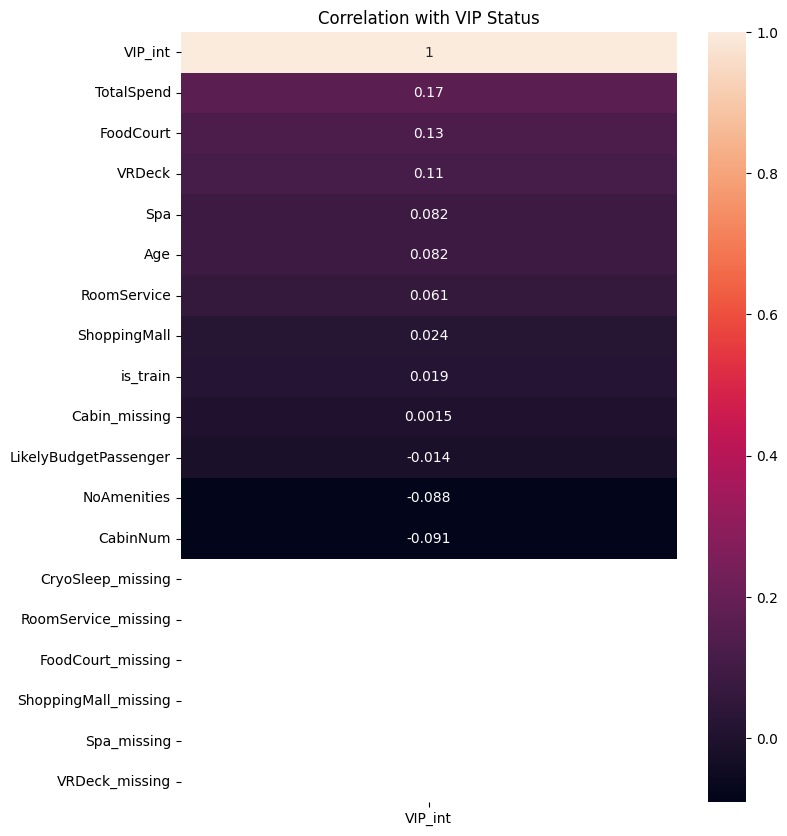

In [19]:
# Encode VIP as int:
combined['VIP_int'] = combined['VIP'].map({True: 1, False: 0})

# Make sure TotalSpend is defined:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
combined['TotalSpend'] = combined[amenities].sum(axis=1)

# Grab numeric features:
numeric_cols = combined.select_dtypes(include=['int64', 'float64', 'bool']).columns
correlations = combined[numeric_cols].corr()['VIP_int'].sort_values(key=abs, ascending=False)
print(correlations)

# Visual inspection
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))
sns.heatmap(combined[numeric_cols].corr()[['VIP_int']].sort_values(by='VIP_int', ascending=False), annot=True)
plt.title('Correlation with VIP Status')
plt.show()


| Feature                | Correlation (VIP) | Comment                                                                                                        |
| ---------------------- | ----------------- | -------------------------------------------------------------------------------------------------------------- |
| `TotalSpend`           | **0.17**          | Most predictive. Not huge, but signal is there.                                                                |
| `FoodCourt` / `VRDeck` | \~0.11–0.13       | Luxury amenities = more likely VIP.                                                                            |
| `CabinNum`             | -0.09             | Negative correlation → lower-numbered cabins more likely to be VIP. Maybe cabins were assigned in price tiers. |
| `NoAmenities`          | -0.088            | Strong hint: no spend = likely not VIP.                                                                        |
| `Age`, `Spa`           | \~0.08            | Modest signal — older travelers and spa users skew slightly toward VIP.                                        |


Infer VIP Status
Here’s how we can approach filling in missing VIP values:

1. Cabin Mates (high confidence)
If a missing-VIP passenger shares a `Cabin` with a known VIP, assume the same status.

2. Spend-Based Heuristic (medium confidence)
If `TotalSpend` is above a certain percentile, and `NoAmenities == False`, then likely VIP.

Let’s test this:

In [20]:
# VIP spend distribution:
vip_spend = combined.loc[combined['VIP'] == True, 'TotalSpend']
nonvip_spend = combined.loc[combined['VIP'] == False, 'TotalSpend']

# Quick percentiles
print("VIP 75th percentile spend:", vip_spend.quantile(0.75))
print("Non-VIP 75th percentile spend:", nonvip_spend.quantile(0.75))


VIP 75th percentile spend: 6206.0
Non-VIP 75th percentile spend: 1382.0


Breakdown:

- VIPs 75th percentile spend: 6206

- Non-VIPs 75th percentile spend: 1382

So spending over **6k** is rare for non-VIPs and normal for VIPs. That gives us strong separation.

Heuristic Rules for Inference:

1. Cabin-mate rule (highest confidence):

(Use `ffill` and `bfill` in case passengers with the same cabin are not in consecutive rows.)

In [21]:
# Fill missing VIPs based on cabinmates:
cabin_vip_map = combined.groupby('Cabin')['VIP'].transform(lambda x: x.ffill().bfill())
combined['VIP_inferred_cabin'] = combined['VIP']
combined.loc[combined['VIP'].isna(), 'VIP_inferred_cabin'] = cabin_vip_map


C:\Users\andre\AppData\Local\Temp\ipykernel_10236\1921186613.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cabin_vip_map = combined.groupby('Cabin')['VIP'].transform(lambda x: x.ffill().bfill())


2. Spend-based inference (fallback):

In [22]:
# Define threshold from earlier:
likely_vip_spend_thresh = 6206  # from VIP 75th percentile

# Only apply to rows where VIP is still NaN:
high_spender_mask = (
    combined['VIP'].isna() &
    (combined['TotalSpend'] >= likely_vip_spend_thresh) &
    (combined['NoAmenities'] == False)
)

# Fill in those with likely VIP = True:
combined.loc[high_spender_mask, 'VIP_inferred_cabin'] = True


In [23]:
# Total remaining NaNs after inference
remaining_missing_vips = combined['VIP_inferred_cabin'].isna().sum()
print(f"Remaining missing VIPs: {remaining_missing_vips}")

initial_missing_vips = combined['VIP'].isna().sum()
inferred_vips = initial_missing_vips - remaining_missing_vips
print(f"Inferred VIPs: {inferred_vips} out of {initial_missing_vips} ({(inferred_vips / initial_missing_vips * 100):.2f}%)")



Remaining missing VIPs: 184
Inferred VIPs: 112 out of 296 (37.84%)


Inference confidence tracker:

In [24]:
# Initialize with 'known'
combined['VIP_confidence'] = 'known'

# Mark cabin-based inference
combined.loc[combined['VIP'].isna() & cabin_vip_map.notna(), 'VIP_confidence'] = 'high_cabin'

# Mark spend-based inference (only if still NaN)
combined.loc[high_spender_mask, 'VIP_confidence'] = 'medium_spend'

# Fill remaining missing with NaN confidence
combined.loc[combined['VIP_inferred_cabin'].isna(), 'VIP_confidence'] = 'missing'

# Sanity breakdown
vip_check = combined.groupby('VIP_confidence')['VIP_inferred_cabin'].value_counts(dropna=False)
print(vip_check)



VIP_confidence  VIP_inferred_cabin
high_cabin      False                    90
known           False                 12401
                True                    273
medium_spend    True                     22
missing         NaN                     184
Name: count, dtype: int64


In [25]:
# VIP Confidence Summary
vip_confidence_summary = combined.groupby('VIP_confidence')['VIP_inferred_cabin'].value_counts(dropna=False)
print(vip_confidence_summary)


VIP_confidence  VIP_inferred_cabin
high_cabin      False                    90
known           False                 12401
                True                    273
medium_spend    True                     22
missing         NaN                     184
Name: count, dtype: int64


create a single cleaned column from all this.

In [26]:
# Final cleaned VIP column
combined['VIP_cleaned'] = combined['VIP']

# Fill with inferred where appropriate
combined.loc[combined['VIP_confidence'] == 'medium_spend', 'VIP_cleaned'] = True
combined.loc[combined['VIP_confidence'] == 'high_cabin', 'VIP_cleaned'] = False

# Still some NaNs left?
print('Remaining VIP_cleaned NaNs:', combined['VIP_cleaned'].isna().sum())
# Drop redundant columns
combined.drop(['VIP', 'VIP_int', 'VIP_inferred_cabin'], axis=1, inplace=True)


Remaining VIP_cleaned NaNs: 184


In [27]:
print("\nMissing Values:")
print(combined.isnull().sum().sort_values(ascending=False))


Missing Values:
Transported              4277
Name                      294
Surname                   294
Destination               274
Age                       270
VIP_cleaned               184
HomePlanet                  0
RoomService                 0
Cabin                       0
FoodCourt                   0
ShoppingMall                0
VRDeck                      0
Spa                         0
CryoSleep                   0
PassengerId                 0
GroupID                     0
is_train                    0
CabinSide                   0
CabinDeck                   0
Cabin_missing               0
NoAmenities                 0
LikelyBudgetPassenger       0
CabinNum                    0
CryoSleep_missing           0
RoomService_missing         0
ShoppingMall_missing        0
FoodCourt_missing           0
Spa_missing                 0
VRDeck_missing              0
TotalSpend                  0
VIP_confidence              0
dtype: int64


Let's see if it's safe to guess the rest as false.

In [28]:
vip_rate = (combined['VIP_cleaned'] == True).sum() / len(combined)
print(f"VIP Rate: {vip_rate:.2%}")


VIP Rate: 2.27%


VIP Rate: 2.27% : very rare class

- Remaining **NaNs**: 184

- Already inferred 112 likely VIPs (~38% of them) using patterns in spend and cabin.

- Therefore... filling the remaining **NaNs** as `False` is statistically safe and reflects the data distribution.

In [29]:
combined['VIP_cleaned'] = combined['VIP_cleaned'].fillna(False)
combined['VIP_confidence'] = combined['VIP_confidence'].replace({np.nan: 'assumed_false'})


C:\Users\andre\AppData\Local\Temp\ipykernel_10236\537670405.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined['VIP_cleaned'] = combined['VIP_cleaned'].fillna(False)


In [30]:
print("\nMissing Values:")
print(combined.isnull().sum().sort_values(ascending=False))


Missing Values:
Transported              4277
Name                      294
Surname                   294
Destination               274
Age                       270
CryoSleep                   0
HomePlanet                  0
RoomService                 0
Cabin                       0
FoodCourt                   0
ShoppingMall                0
VRDeck                      0
Spa                         0
is_train                    0
PassengerId                 0
GroupID                     0
CabinDeck                   0
CabinSide                   0
CabinNum                    0
Cabin_missing               0
NoAmenities                 0
LikelyBudgetPassenger       0
CryoSleep_missing           0
RoomService_missing         0
FoodCourt_missing           0
ShoppingMall_missing        0
Spa_missing                 0
VRDeck_missing              0
TotalSpend                  0
VIP_confidence              0
VIP_cleaned                 0
dtype: int64


Immediate Next Steps:

Destination:

- Try inferring based on GroupID or Surname (like we did for HomePlanet).

- If we can’t infer: check most common within similar groups or flag and fill with mode.

In [31]:
print("Missing Destinations:", combined['Destination'].isna().sum())
print("Unique Destinations:", combined['Destination'].dropna().unique())


Missing Destinations: 274
Unique Destinations: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']


Group-Based Inference (GroupID, Surname)

In [32]:
# Step 1: GroupID-based unique destination
group_destination_map = combined.groupby('GroupID')['Destination'].agg(lambda x: x.dropna().unique())
def infer_destination_from_group(row):
    if pd.isna(row['Destination']):
        dests = group_destination_map.get(row['GroupID'], [])
        if len(dests) == 1:
            return dests[0]
    return row['Destination']
combined['Destination_inferred'] = combined.apply(infer_destination_from_group, axis=1)

# Step 2: Fill the rest using mode
global_mode = combined['Destination'].mode()[0]
combined['Destination_confidence'] = 'known'
combined.loc[combined['Destination'].isna() & combined['Destination_inferred'].notna(), 'Destination_confidence'] = 'inferred'
combined['Destination_inferred'].fillna(global_mode, inplace=True)
combined.loc[combined['Destination'].isna() & (combined['Destination_inferred'] == global_mode), 'Destination_confidence'] = 'assumed_mode'

# Step 3: Final assignment
combined['Destination_cleaned'] = combined['Destination_inferred']
combined.drop(columns=['Destination_inferred'], inplace=True)

combined.drop(columns=['Destination'], inplace=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_10236\4092387815.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined['Destination_inferred'].fillna(global_mode, inplace=True)


Fill Remaining from Surname if Possible

In [33]:
print("Remaining Destination NaNs:", combined['Destination_cleaned'].isna().sum())
print(combined['Destination_confidence'].value_counts())


Remaining Destination NaNs: 0
Destination_confidence
known           12696
assumed_mode      255
inferred           19
Name: count, dtype: int64


In [34]:
print("\nMissing Values:")
print(combined.isnull().sum().sort_values(ascending=False))


Missing Values:
Transported               4277
Name                       294
Surname                    294
Age                        270
Cabin                        0
RoomService                  0
CryoSleep                    0
PassengerId                  0
ShoppingMall                 0
FoodCourt                    0
VRDeck                       0
Spa                          0
is_train                     0
GroupID                      0
CabinDeck                    0
HomePlanet                   0
CabinNum                     0
CabinSide                    0
NoAmenities                  0
Cabin_missing                0
LikelyBudgetPassenger        0
CryoSleep_missing            0
RoomService_missing          0
FoodCourt_missing            0
ShoppingMall_missing         0
Spa_missing                  0
VRDeck_missing               0
TotalSpend                   0
VIP_confidence               0
VIP_cleaned                  0
Destination_confidence       0
Destination_cleaned   

Next: AGE

 Create Age Categories

In [35]:
# Step 1: Categorize known ages
def categorize_age(age):
    if pd.isna(age):
        return np.nan
    elif age < 18:
        return 'child'
    elif age < 60:
        return 'adult'
    else:
        return 'senior'

combined['AgeCategory'] = combined['Age'].apply(categorize_age)

# Step 2: Show the breakdown
age_category_counts = combined['AgeCategory'].value_counts(dropna=False)
print("Age Categories:\n", age_category_counts)

# Step 3: Optional — Show how many missing age values are in each category (should be NaN only)
missing_age_count = combined['Age'].isna().sum()
print(f"\nMissing Age Values: {missing_age_count}")


Age Categories:
 AgeCategory
adult     10058
child      2264
senior      378
NaN         270
Name: count, dtype: int64

Missing Age Values: 270


Impute the 270 missing ages smartly

- We'll do this in tiers of increasing specificity:

Tier 1: GroupID-based inference

If a missing-age passenger is in a GroupID where others have known ages:

- Use the most common AgeCategory in their group

- Assign the mean age of that category to the missing value

In [36]:
# Step 1: Mean ages by category
mean_ages_by_category = combined.groupby('AgeCategory')['Age'].mean()

# Step 2: Build a GroupID → most common age category map
group_age_mode = (
    combined[combined['AgeCategory'].notna()]
    .groupby('GroupID')['AgeCategory']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
)

# Step 3: Function to infer missing ages
def infer_age(row):
    if pd.notna(row['Age']):
        return row['Age'], 'known'
    
    # Try GroupID
    group_cat = group_age_mode.get(row['GroupID'], np.nan)
    if pd.notna(group_cat):
        return mean_ages_by_category[group_cat], f'inferred_group_{group_cat}'
    
    return np.nan, 'unknown'

# Step 4: Apply logic
combined[['Age_filled', 'Age_confidence']] = combined.apply(
    infer_age, axis=1, result_type='expand'
)

print("New missing values in Age_filled:", combined['Age_filled'].isna().sum())
combined['Age_confidence'].value_counts(dropna=False)


New missing values in Age_filled: 144


Age_confidence
known                    12700
unknown                    144
inferred_group_adult        96
inferred_group_child        29
inferred_group_senior        1
Name: count, dtype: int64

Tier 2 Inference Ideas

Step 1: Solo Travelers Are Adults

- Anyone in a GroupID with only 1 person is likely an adult.

In [37]:
# Group sizes
group_sizes = combined.groupby('GroupID')['PassengerId'].count()

# Map GroupID to size
combined['GroupSize'] = combined['GroupID'].map(group_sizes)

# Flag solo travelers
is_solo = (combined['GroupSize'] == 1)

# Assign average adult age for solo travelers with unknown age
solo_adult_fill = (combined['Age'].isna()) & (is_solo)

combined.loc[solo_adult_fill, 'Age'] = mean_ages_by_category['adult']
combined.loc[solo_adult_fill, 'Age_confidence'] = 'inferred_solo_adult'


In [38]:
print("New missing values in Age_filled:", combined['Age_filled'].isna().sum())
combined['Age_confidence'].value_counts(dropna=False)

New missing values in Age_filled: 144


Age_confidence
known                    12700
inferred_solo_adult        142
inferred_group_adult        96
inferred_group_child        29
unknown                      2
inferred_group_senior        1
Name: count, dtype: int64

Nice, we're now accounted for 268 out of 270 missing ages with informed, category-aligned estimates.

I've only got 2 unknowns left. At this point, I think it's acceptable to:

- Fill them both with the overall mean of all known ages

- Or more cleanly, just set them as the mean adult age, since they weren't group- or solo-inferable and are **probably** not children

In [39]:
# Fill final 2 with adult mean
final_unknown = combined['Age_confidence'] == 'unknown'
combined.loc[final_unknown, 'Age'] = mean_ages_by_category['adult']
combined.loc[final_unknown, 'Age_confidence'] = 'assumed_adult'


In [40]:
print("New missing values in Age_filled:", combined['Age_filled'].isna().sum())
combined['Age_confidence'].value_counts(dropna=False)

New missing values in Age_filled: 144


Age_confidence
known                    12700
inferred_solo_adult        142
inferred_group_adult        96
inferred_group_child        29
assumed_adult                2
inferred_group_senior        1
Name: count, dtype: int64

In [41]:
print("\nMissing Values:")
print(combined.isnull().sum().sort_values(ascending=False))


Missing Values:
Transported               4277
Name                       294
Surname                    294
AgeCategory                270
Age_filled                 144
Age                        126
HomePlanet                   0
PassengerId                  0
Cabin                        0
CryoSleep                    0
ShoppingMall                 0
RoomService                  0
is_train                     0
GroupID                      0
CabinDeck                    0
CabinNum                     0
CabinSide                    0
FoodCourt                    0
VRDeck                       0
Spa                          0
LikelyBudgetPassenger        0
NoAmenities                  0
Cabin_missing                0
CryoSleep_missing            0
ShoppingMall_missing         0
Spa_missing                  0
RoomService_missing          0
FoodCourt_missing            0
TotalSpend                   0
VRDeck_missing               0
VIP_confidence               0
VIP_cleaned           

These are now stale or redundant:

- Age_filled: everything's in Age

- AgeCategory: served its purpose for group inference

In [42]:
combined.drop(columns=['Age_filled', 'AgeCategory'], inplace=True)